# Words-documents network analysis

In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

import archetypes as arch
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def number_normalizer(tokens):
    """Map all numeric tokens to a placeholder.

    For many applications, tokens that begin with a number are not directly
    useful, but the fact that such a token exists can be relevant.  By applying
    this form of dimensionality reduction, some methods may perform better.
    """
    return ("#NUMBER" if token[0].isdigit() else token for token in tokens)

In [3]:
class NumberNormalizingVectorizer(TfidfVectorizer):
    def build_tokenizer(self):
        tokenize = super().build_tokenizer()
        return lambda doc: list(number_normalizer(tokenize(doc)))

In [4]:
categories = ['rec.autos', 'rec.sport.hockey', "talk.politics.guns"]

newsgroups = fetch_20newsgroups(categories=categories)
data = newsgroups.data[:]
target = newsgroups.target[:]

# samples = np.random.choice(len(data), 100)
# data = [data[i] for i in samples]
# target = [target[i] for i in samples]

target_names = newsgroups.target_names

vectorizer = NumberNormalizingVectorizer(stop_words="english", min_df=0.02, max_df=0.3)

X = vectorizer.fit_transform(data).toarray()
words = vectorizer.get_feature_names_out()

In [5]:
X.shape

(1740, 1008)

## BiArchetype Analysis

In [6]:
biaa = arch.BiAA(n_archetypes=(4, 4), max_iter=10_000, n_init=5, random_state=123)
_ = biaa.fit(X)

In [7]:
biaa_row_probs = biaa.alphas_
biaa_col_probs = biaa.gammas_.T

In [8]:
biaa_row_rep = biaa_row_probs.argmax(axis=0)
biaa_col_rep = biaa_col_probs.argmax(axis=0)

## Louvain method

In [9]:
from sknetwork.clustering import Louvain

louvain = Louvain(resolution=1.0, n_aggregations=10, sort_clusters=True)
louvain.fit(X)

labels = louvain.labels_
labels_col = louvain.labels_col_

In [10]:
louvain_row_probs = louvain.predict_proba(columns=False)
louvain_col_probs = louvain.predict_proba(columns=True)

In [11]:
louvain_row_rep = louvain_row_probs.argmax(axis=0)
louvain_col_rep = louvain_col_probs.argmax(axis=0)

## Spectral Biclustering

In [12]:
# import spatial coclustering

from sklearn.cluster import SpectralBiclustering

biclus = SpectralBiclustering(n_clusters=(3, 3), method='log', random_state=0)
_ = biclus.fit(X)

c:\Users\aalcacer\Miniconda3\envs\archetypes\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\aalcacer\Miniconda3\envs\archetypes\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\aalcacer\Miniconda3\envs\archetypes\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\aalcacer\Miniconda3\envs\archetypes\lib\site-packages\sklearn\clust

In [13]:
biclus_row_labels = biclus.row_labels_
biclus_column_labels = biclus.column_labels_

In [14]:
from scipy.spatial.distance import cdist

biclus_row_rep = np.zeros(biclus.n_clusters[0], dtype=int)
for i in range(biclus.n_clusters[0]):
    row_indices, _ = biclus.get_indices(i * biclus.n_clusters[1])
    biclus_row_rep[i] = row_indices[cdist(X[row_indices, :], X[row_indices, :]).sum(axis=1).argmin()]

biclus_col_rep = np.zeros(biclus.n_clusters[1], dtype=int)
for j in range(biclus.n_clusters[1]):
    _, col_indices = biclus.get_indices(j)
    biclus_col_rep[j] = col_indices[cdist(X[:, col_indices].T, X[:, col_indices].T).sum(axis=1).argmin()]


## Spectral Co-clustering

In [15]:
# import spatial coclustering

from sklearn.cluster import SpectralCoclustering

coclus = SpectralCoclustering(n_clusters=(3), random_state=0)
_ = coclus.fit(X)

c:\Users\aalcacer\Miniconda3\envs\archetypes\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(


In [16]:
coclus_row_labels = coclus.row_labels_
coclus_column_labels = coclus.column_labels_

In [17]:
from scipy.spatial.distance import cdist

coclus_row_rep = np.zeros(coclus.n_clusters, dtype=int)
coclus_col_rep = np.zeros(coclus.n_clusters, dtype=int)

for i in range(coclus.n_clusters):
    row_indices, col_indices = coclus.get_indices(i)
    coclus_row_rep[i] = row_indices[cdist(X[row_indices, :], X[row_indices, :]).sum(axis=1).argmin()]
    coclus_col_rep[i] = col_indices[cdist(X[:, col_indices].T, X[:, col_indices].T).sum(axis=1).argmin()]


## PCA

In [18]:
rep_marker = "+"
rep_s = 100

from matplotlib import colormaps
rep_cmap = colormaps.get_cmap('Dark2')

In [25]:
def plot_convex_hull(points, color, ax):
    from scipy.spatial import ConvexHull
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        ax.plot(points[simplex, 0], points[simplex, 1], color=color, alpha=0.2)

    # fill hull
    ax.fill(points[hull.vertices, 0], points[hull.vertices, 1], color=color, alpha=0.05)

    # compute the area of the hull
    area = hull.volume

    # annotate in one of the vertices
    # ax.text(points[hull.vertices[0], 0], points[hull.vertices[0], 1], f'{area:.2f}', fontsize=8, color=color)

    return ax


### Documents

In [26]:
def jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

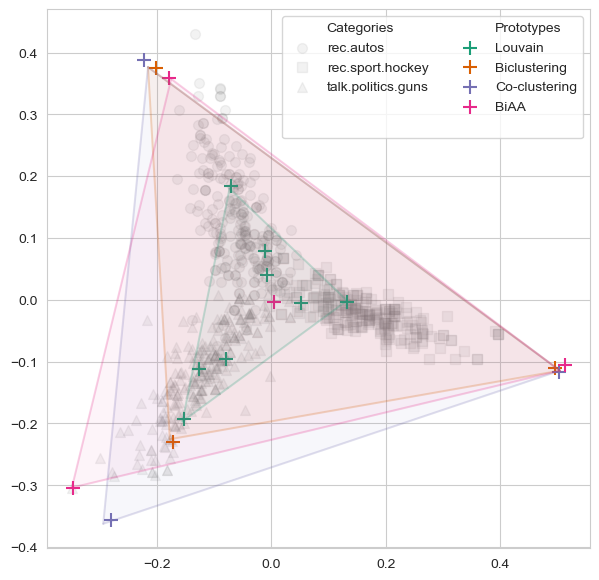

In [27]:
# Apply PCA to X

from sklearn.decomposition import PCA

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X)

X_2d = X_pca

# convert list of labels to list of markers
target_0 = np.array(target) == 0
target_1 = np.array(target) == 1
target_2 = np.array(target) == 2

plt.figure(figsize=(7, 7))

sample_0 = np.random.choice(np.where(target_0)[0], 250)
sample_1 = np.random.choice(np.where(target_1)[0], 250)
sample_2 = np.random.choice(np.where(target_2)[0], 250)

plt.scatter(X_2d[sample_0, 0], X_2d[sample_0, 1], s=50, color="gray", alpha=.1, marker='o', label=target_names[0])
plt.scatter(X_2d[sample_1, 0], X_2d[sample_1, 1], s=50, color="gray", alpha=.1, marker='s', label=target_names[1])
plt.scatter(X_2d[sample_2, 0], X_2d[sample_2, 1], s=50, color="gray", alpha=.1, marker='^', label=target_names[2])

# plt.scatter(X_2d[target_0, 0], X_2d[target_0, 1], s=50, color="gray", alpha=.1, marker='o', label=target_names[0])
# plt.scatter(X_2d[target_1, 0], X_2d[target_1, 1], s=50, color="gray", alpha=.1, marker='s', label=target_names[1])
# plt.scatter(X_2d[target_2, 0], X_2d[target_2, 1], s=50, color="gray", alpha=.1, marker='^', label=target_names[2])

# plot louvain rep
plt.scatter(
    jitter(X_2d[louvain_row_rep, 0]),
    jitter(X_2d[louvain_row_rep, 1]),
    s=rep_s, color=rep_cmap(0), marker=rep_marker, label='Louvain')

# plot biclus medoids
plt.scatter(
    jitter(X_2d[biclus_row_rep, 0]),
    jitter(X_2d[biclus_row_rep, 1]),
    s=rep_s, color=rep_cmap(1), marker=rep_marker, label='Biclustering')

# plot coclus medoids
plt.scatter(
    jitter(X_2d[coclus_row_rep, 0]),
    jitter(X_2d[coclus_row_rep, 1]),
    s=rep_s, color=rep_cmap(2), marker=rep_marker, label='Co-clustering')

# plot biaa rep
plt.scatter(
    jitter(X_2d[biaa_row_rep, 0]),
    jitter(X_2d[biaa_row_rep, 1]),
    s=rep_s, color=rep_cmap(3), marker=rep_marker, label='BiAA')

# plot convex hulls
ax = plt.gca()
plot_convex_hull(X_2d[louvain_row_rep], rep_cmap(0), ax)
plot_convex_hull(X_2d[biclus_row_rep], rep_cmap(1), ax)
plot_convex_hull(X_2d[coclus_row_rep], rep_cmap(2), ax)
plot_convex_hull(X_2d[biaa_row_rep], rep_cmap(3), ax)

plt.legend()

# Get legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

from matplotlib.lines import Line2D
# Add a title in the position 0 of the legend
handles.insert(0, Line2D([0],[0],color="w"))
labels.insert(0, 'Categories')

handles.insert(4, Line2D([0],[0],color="w"))
labels.insert(4, '')
handles.insert(5, Line2D([0],[0],color="w"))
labels.insert(5, '')

handles.insert(6, Line2D([0],[0],color="w"))
labels.insert(6, 'Prototypes')

plt.legend(handles, labels, loc='upper right', ncol=2)

# save figure as pdf
plt.savefig('../figures/pca_documents.pdf', bbox_inches='tight')

plt.show()


### Words

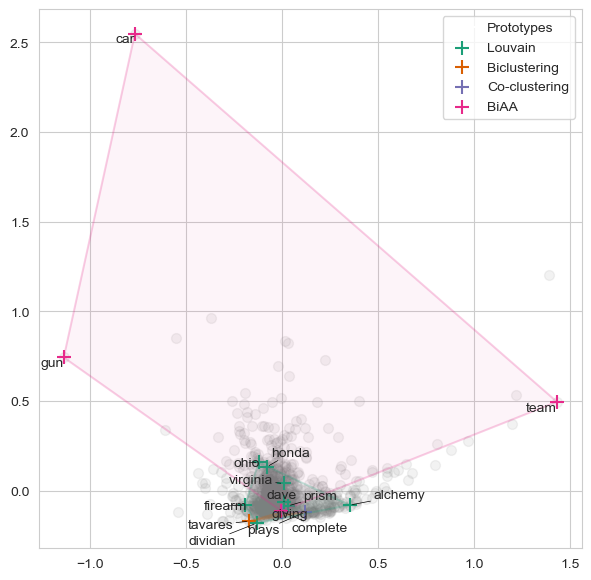

In [29]:
# Apply PCA to X

from sklearn.decomposition import PCA

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X.T)

X_2d = X_pca

# plot the results
from adjustText import adjust_text

plt.figure(figsize=(7, 7))
plt.scatter(X_2d[:, 0], X_2d[:, 1], s=50, c="gray", alpha=0.1)


# plot louvain rep
plt.scatter(X_2d[louvain_col_rep, 0], X_2d[louvain_col_rep, 1], s=rep_s, color=rep_cmap(0), marker=rep_marker, label='Louvain')

# plot biclus medoids
plt.scatter(X_2d[biclus_col_rep, 0], X_2d[biclus_col_rep, 1], s=rep_s, color=rep_cmap(1), marker=rep_marker, label='Biclustering')

# plot coclus medoids
plt.scatter(X_2d[coclus_col_rep, 0], X_2d[coclus_col_rep, 1], s=rep_s, color=rep_cmap(2), marker=rep_marker, label='Co-clustering')

# plot biaa rep
plt.scatter(X_2d[biaa_col_rep, 0], X_2d[biaa_col_rep, 1], s=rep_s, color=rep_cmap(3), marker=rep_marker, label='BiAA')

# plot convex hulls
ax = plt.gca()

plot_convex_hull(X_2d[louvain_col_rep], rep_cmap(0), ax)
plot_convex_hull(X_2d[biclus_col_rep], rep_cmap(1), ax)
plot_convex_hull(X_2d[coclus_col_rep], rep_cmap(2), ax)
plot_convex_hull(X_2d[biaa_col_rep], rep_cmap(3), ax)

texts = []
for i in np.unique(np.concatenate([biclus_col_rep, louvain_col_rep, biaa_col_rep])):
    texts.append(plt.text(X_2d[i, 0], X_2d[i, 1], words[i], fontsize=10))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='k', lw=0.5), expand=(1.2, 1.2))

plt.legend()

# Get legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

from matplotlib.lines import Line2D
# Add a title in the position 0 of the legend
handles.insert(0, Line2D([0],[0],color="w"))
labels.insert(0, 'Prototypes')

plt.legend(handles, labels, loc='upper right')

# save figure as pdf
plt.savefig('../figures/pca_words.pdf', bbox_inches='tight')

plt.show()


## Top-5 words per cluster

In [30]:
import pandas as pd
import seaborn as sns

def plot_top_words(probs, words, top_n=5, ax=None):
    top_words = pd.DataFrame(columns=['Prototype', 'Word', 'Score'])

    for i in range(probs.shape[1]):
        top_words_i = np.argsort(probs[:, i])[-top_n:][::-1]
        for j in range(len(top_words_i)):
            word = words[top_words_i[j]]
            score = probs[top_words_i[j], i]
            cluster = i
            rank = j
            top_words = top_words.append({'Prototype': cluster, 'Rank': rank, 'Word': word, 'Score': score}, ignore_index=True)

    # Create a heatmap of the top words per cluster
    top_words_pivot = top_words.pivot(index='Rank', columns='Prototype', values='Word')
    top_scores_pivot = top_words.pivot(index='Rank', columns='Prototype', values='Score')

    if ax is None:
        fig, ax = plt.subplots(figsize=(1.5 * probs.shape[1], 0.3 * top_n))

    sns.heatmap(top_scores_pivot, annot=top_words_pivot, fmt='', cmap='Blues', vmin=0, vmax=1, ax=ax,
                cbar_kws={"aspect": 10, "pad": 0.1 / probs.shape[1]}
                )

    # remove y axis ticks
    ax.set_yticks([])
    ax.set_ylabel(f'Top-{top_n} words')

    # add title to the sns cmap in legend
    ax.collections[0].colorbar.set_label('Similarity')

    # transform to 50% the colorbar size
    ax.collections[0].colorbar.ax.set_yticks(np.linspace(0, 1, 2))
    ax.collections[0].colorbar.ax.set_yticklabels(['0%', '100%'])
    return ax


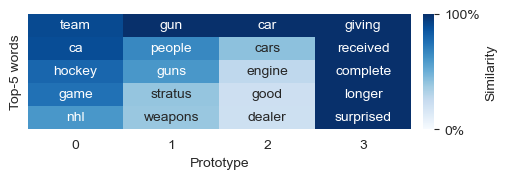

In [23]:
plot_top_words(biaa_col_probs, words, top_n=5)

plt.savefig('../figures/top_words_biaa.pdf', bbox_inches='tight')

plt.show()

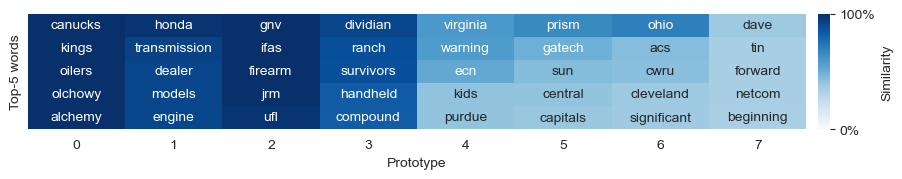

In [24]:
plot_top_words(louvain_col_probs, words, top_n=5)

plt.savefig('../figures/top_words_louvain.pdf', bbox_inches='tight')

plt.show()